In [21]:
import fuzzingbook.bookutils.setup
from fuzzingbook.Coverage import Coverage
import inspect

In [22]:
def triangle(a, b, c):
    if a == b:
        if b == c:
            return "Equilateral"
        else:
            return "Isosceles"
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"


def strong_oracle(fn):
    assert fn(1, 1, 1) == "Equilateral"

    assert fn(1, 2, 1) == "Isosceles"
    assert fn(2, 2, 1) == "Isosceles"
    assert fn(1, 2, 2) == "Isosceles"

    assert fn(1, 2, 3) == "Scalene"

In [23]:
class VisualCoverage(Coverage):
    def show_coverage(self, fn):
        src = inspect.getsource(fn)
        name = fn.__name__
        covered = set([lineno for method, lineno in self._trace if method == name])

        for i, s in enumerate(src.split("\n")):
            print("%s %2d: %s" % ("#" if i + 1 in covered else " ", i + 1, s))

In [24]:
with VisualCoverage() as cov:
    strong_oracle(triangle)

In [25]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return "Equilateral"
   5:         else:
#  6:             return "Isosceles"
   7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
  10:         else:
# 11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
# 14:                 return "Scalene"
  15: 


In [26]:
def weak_oracle(fn):
    assert fn(1, 1, 1) == "Equilateral"

    assert fn(1, 2, 1) != "Equilateral"
    assert fn(2, 2, 1) != "Equilateral"
    assert fn(1, 2, 2) != "Equilateral"

    assert fn(1, 2, 3) != "Equilateral"

In [27]:
with VisualCoverage() as cov:
    weak_oracle(triangle)

In [28]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return "Equilateral"
   5:         else:
#  6:             return "Isosceles"
   7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
  10:         else:
# 11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
# 14:                 return "Scalene"
  15: 


In [29]:
def triangle_m1(a, b, c):
    if a == b:
        if b == c:
            return "Equilateral"
        else:
            return None
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

In [30]:
from fuzzingbook.ExpectError import ExpectError

with ExpectError():
    weak_oracle(triangle_m1)

with ExpectError():
    strong_oracle(triangle_m1)

Traceback (most recent call last):
  File "/tmp/ipykernel_11615/3597030570.py", line 7, in <module>
    strong_oracle(triangle_m1)
  File "/tmp/ipykernel_11615/3234387017.py", line 21, in strong_oracle
    assert fn(2, 2, 1) == "Isosceles"
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError (expected)


In [31]:
import ast

triangle_source = inspect.getsource(triangle)
triangle_source

'def triangle(a, b, c):\n    if a == b:\n        if b == c:\n            return "Equilateral"\n        else:\n            return "Isosceles"\n    else:\n        if b == c:\n            return "Isosceles"\n        else:\n            if a == c:\n                return "Isosceles"\n            else:\n                return "Scalene"\n'

In [32]:
from fuzzingbook.bookutils import print_content

print_content(triangle_source, ".py")

def triangle(a, b, c):
    if a == b:
        if b == c:
            return "Equilateral"
        else:
            return "Isosceles"
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

In [33]:
triangle_ast = ast.parse(triangle_source)

In [34]:
print(ast.dump(triangle_ast, indent=4))

Module(
    body=[
        FunctionDef(
            name='triangle',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='a'),
                    arg(arg='b'),
                    arg(arg='c')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                If(
                    test=Compare(
                        left=Name(id='a', ctx=Load()),
                        ops=[
                            Eq()],
                        comparators=[
                            Name(id='b', ctx=Load())]),
                    body=[
                        If(
                            test=Compare(
                                left=Name(id='b', ctx=Load()),
                                ops=[
                                    Eq()],
                                comparators=[
                                    Name(id='c', ctx=Load())]),
              

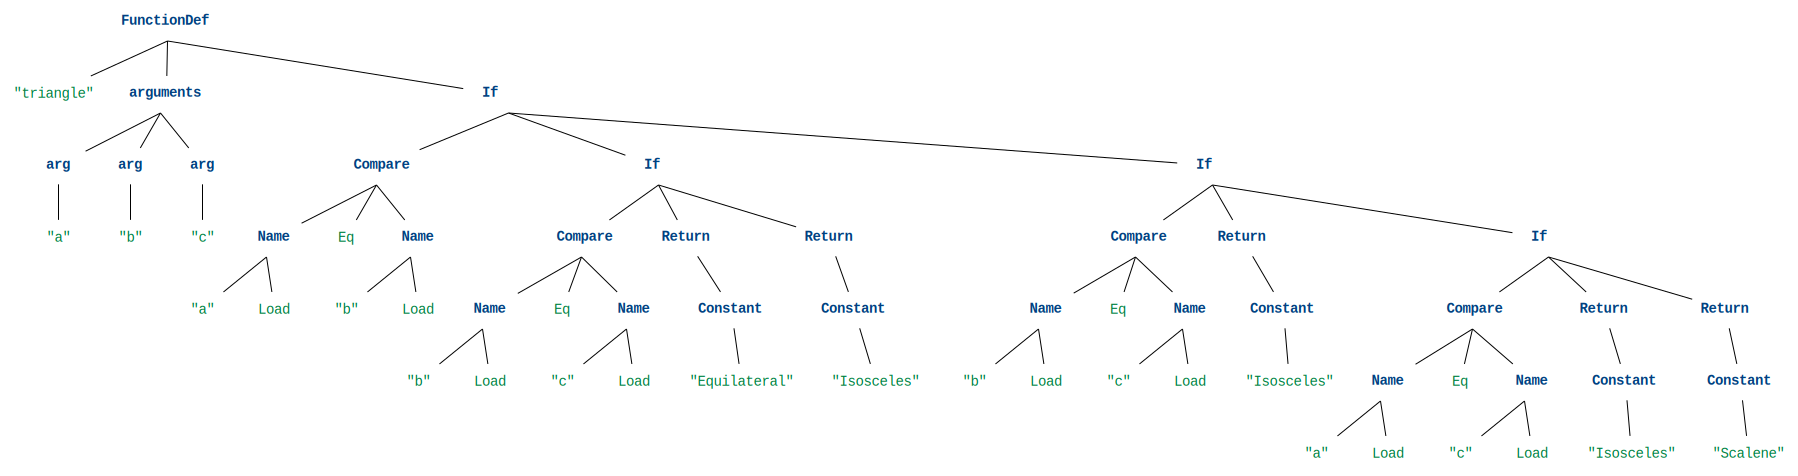

In [35]:
from fuzzingbook.bookutils import rich_output

if rich_output():
    import showast

    showast.show_ast(triangle_ast)

In [36]:
print_content(ast.unparse(triangle_ast), ".py")

def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    elif b == c:
        return 'Isosceles'
    elif a == c:
        return 'Isosceles'
    else:
        return 'Scalene'

In [37]:
class Mutator(ast.NodeTransformer):
    def __init__(self, mutate_location=-1):
        self.count = 0
        self.mutate_location = mutate_location

    def mutable_visit(self, node):
        self.count += 1
        if self.count == self.mutate_location:
            return self.mutation_visit(node)
        return self.generic_visit(node)

In [38]:
class StmtDeletionMutator(Mutator):
    def visit_Return(self, node):
        return self.mutable_visit(node)

    def visit_Delete(self, node):
        return self.mutable_visit(node)

    def visit_Assign(self, node):
        return self.mutable_visit(node)

    def visit_AnnAssign(self, node):
        return self.mutable_visit(node)

    def visit_AugAssign(self, node):
        return self.mutable_visit(node)

    def visit_Raise(self, node):
        return self.mutable_visit(node)

    def visit_Assert(self, node):
        return self.mutable_visit(node)

    def visit_Global(self, node):
        return self.mutable_visit(node)

    def visit_Nonlocal(self, node):
        return self.mutable_visit(node)

    def visit_Expr(self, node):
        return self.mutable_visit(node)

    def visit_Pass(self, node):
        return self.mutable_visit(node)

    def visit_Break(self, node):
        return self.mutable_visit(node)

    def visit_Continue(self, node):
        return self.mutable_visit(node)

In [39]:
class MuFunctionAnalyzer:
    def __init__(self, fn, log=False):
        self.fn = fn
        self.name = fn.__name__
        src = inspect.getsource(fn)
        self.ast = ast.parse(src)
        self.src = ast.unparse(self.ast)  # normalize
        self.mutator = self.mutator_object()
        self.nmutations = self.get_mutation_count()
        self.un_detected = set()
        self.mutants = []
        self.log = log

    def mutator_object(self, locations=None):
        return StmtDeletionMutator(locations)

    def register(self, m):
        self.mutants.append(m)

    def finish(self):
        pass

In [40]:
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def get_mutation_count(self):
        self.mutator.visit(self.ast)
        return self.mutator.count

In [41]:
class StmtDeletionMutator(StmtDeletionMutator):
    def mutation_visit(self, node):
        return ast.Pass()

In [42]:
MuFunctionAnalyzer(triangle).nmutations

5

In [43]:
class PMIterator:
    def __init__(self, pm):
        self.pm = pm
        self.idx = 0


class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def __iter__(self):
        return PMIterator(self)

In [44]:
class Mutant:
    def __init__(self, pm, location, log=False):
        self.pm = pm
        self.i = location
        self.name = "%s_%s" % (self.pm.name, self.i)
        self._src = None
        self.tests = []
        self.detected = False
        self.log = log

In [45]:
class PMIterator(PMIterator):
    def __next__(self):
        i = self.idx
        if i >= self.pm.nmutations:
            self.pm.finish()
            raise StopIteration()
        self.idx += 1
        mutant = Mutant(self.pm, self.idx, log=self.pm.log)
        self.pm.register(mutant)
        return mutant

In [46]:
for m in MuFunctionAnalyzer(triangle):
    print(m.name)

triangle_1
triangle_2
triangle_3
triangle_4
triangle_5


In [47]:
class Mutant(Mutant):
    def generate_mutant(self, location):
        mutant_ast = self.pm.mutator_object(location).visit(ast.parse(self.pm.src))
        return ast.unparse(mutant_ast)


class Mutant(Mutant):
    def src(self):
        if self._src is None:
            self._src = self.generate_mutant(self.i)
        return self._src

In [48]:
import difflib

for mutant in MuFunctionAnalyzer(triangle):
    shape_src = mutant.pm.src
    for line in difflib.unified_diff(
        mutant.pm.src.split("\n"),
        mutant.src().split("\n"),
        fromfile=mutant.pm.name,
        tofile=mutant.name,
        n=3,
    ):
        print(line)

--- triangle

+++ triangle_1

@@ -1,7 +1,7 @@

 def triangle(a, b, c):
     if a == b:
         if b == c:
-            return 'Equilateral'
+            pass
         else:
             return 'Isosceles'
     elif b == c:
--- triangle

+++ triangle_2

@@ -3,7 +3,7 @@

         if b == c:
             return 'Equilateral'
         else:
-            return 'Isosceles'
+            pass
     elif b == c:
         return 'Isosceles'
     elif a == c:
--- triangle

+++ triangle_3

@@ -5,7 +5,7 @@

         else:
             return 'Isosceles'
     elif b == c:
-        return 'Isosceles'
+        pass
     elif a == c:
         return 'Isosceles'
     else:
--- triangle

+++ triangle_4

@@ -7,6 +7,6 @@

     elif b == c:
         return 'Isosceles'
     elif a == c:
-        return 'Isosceles'
+        pass
     else:
         return 'Scalene'
--- triangle

+++ triangle_5

@@ -9,4 +9,4 @@

     elif a == c:
         return 'Isosceles'
     else:
-        return 'Scalene'
+        pass


In [49]:
class Mutant(Mutant):
    def diff(self):
        return "\n".join(
            difflib.unified_diff(
                self.pm.src.split("\n"),
                self.src().split("\n"),
                fromfile="original",
                tofile="mutant",
                n=3,
            )
        )

In [50]:
class Mutant(Mutant):
    def __enter__(self):
        if self.log:
            print("->\t%s" % self.name)
        c = compile(self.src(), "<mutant>", "exec")
        eval(c, globals())

In [51]:
class Mutant(Mutant):
    def __exit__(self, exc_type, exc_value, traceback):
        if self.log:
            print("<-\t%s" % self.name)
        if exc_type is not None:
            self.detected = True
            if self.log:
                print("Detected %s" % self.name, exc_type, exc_value)
        globals()[self.pm.name] = self.pm.fn
        if self.log:
            print()
        return True

In [52]:
from fuzzingbook.ExpectError import ExpectTimeout


class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def finish(self):
        self.un_detected = {mutant for mutant in self.mutants if not mutant.detected}


class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def score(self):
        return (self.nmutations - len(self.un_detected)) / self.nmutations

In [53]:
for mutant in MuFunctionAnalyzer(triangle):
    with mutant:
        weak_oracle(triangle)
mutant.pm.score()

0.2

In [54]:
def gcd(a, b):
    if a < b:
        c = a
        a = b
        b = c

    while b != 0:
        c = a
        a = b
        b = c % b
    return a

In [55]:
for mutant in MuFunctionAnalyzer(gcd, log=True):
    with mutant:
        assert gcd(1, 0) == 1, "Minimal"
        assert gcd(0, 1) == 1, "Mirror"

->	gcd_1
<-	gcd_1
Detected gcd_1 <class 'UnboundLocalError'> cannot access local variable 'c' where it is not associated with a value

->	gcd_2
<-	gcd_2
Detected gcd_2 <class 'AssertionError'> Mirror

->	gcd_3
<-	gcd_3

->	gcd_4
<-	gcd_4

->	gcd_5
<-	gcd_5

->	gcd_6
<-	gcd_6

->	gcd_7
<-	gcd_7
Detected gcd_7 <class 'AssertionError'> Minimal



In [56]:
mutant.pm.score()

0.42857142857142855

In [ ]:
import types


def import_code(code, name):
    module = types.ModuleType(name)
    exec(code, module.__dict__)
    return module


shape = import_code(shape_src, "shape")

shape.triangle(1, 1, 1)

'Equilateral'

In [ ]:
import unittest


class StrongShapeTest(unittest.TestCase):

    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == "Equilateral"

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) == "Isosceles"
        assert shape.triangle(2, 2, 1) == "Isosceles"
        assert shape.triangle(1, 2, 2) == "Isosceles"

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) == "Scalene"

In [ ]:
def suite(test_class):
    suite = unittest.TestSuite()
    for f in test_class.__dict__:
        if f.startswith("test_"):
            suite.addTest(test_class(f))
    return suite

In [60]:
suite(StrongShapeTest).run(unittest.TestResult())

<unittest.result.TestResult run=3 errors=0 failures=0>

In [ ]:
runner = unittest.TextTestRunner(verbosity=0, failfast=True)
runner.run(suite(StrongShapeTest))

----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [62]:
with VisualCoverage() as cov:
    suite(StrongShapeTest).run(unittest.TestResult())

In [63]:
cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return "Equilateral"
   5:         else:
#  6:             return "Isosceles"
#  7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
# 10:         else:
  11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
  14:                 return "Scalene"
  15: 


In [ ]:
class WeakShapeTest(unittest.TestCase):
    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == "Equilateral"

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) != "Equilateral"
        assert shape.triangle(2, 2, 1) != "Equilateral"
        assert shape.triangle(1, 2, 2) != "Equilateral"

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) != "Equilateral"

In [65]:
with VisualCoverage() as cov:
    suite(WeakShapeTest).run(unittest.TestResult())

cov.show_coverage(triangle)

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return "Equilateral"
   5:         else:
#  6:             return "Isosceles"
#  7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
# 10:         else:
  11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
  14:                 return "Scalene"
  15: 


In [ ]:
class MuProgramAnalyzer(MuFunctionAnalyzer):
    def __init__(self, name, src):
        self.name = name
        self.ast = ast.parse(src)
        self.src = ast.unparse(self.ast)
        self.changes = []
        self.mutator = self.mutator_object()
        self.nmutations = self.get_mutation_count()
        self.un_detected = set()

    def mutator_object(self, locations=None):
        return AdvStmtDeletionMutator(self, locations)

In [ ]:
class AdvMutator(Mutator):
    def __init__(self, analyzer, mutate_locations=None):
        self.count = 0
        self.mutate_locations = [] if mutate_locations is None else mutate_locations
        self.pm = analyzer

    def mutable_visit(self, node):
        self.count += 1
        return self.mutation_visit(node)

In [ ]:
class AdvStmtDeletionMutator(AdvMutator, StmtDeletionMutator):
    def __init__(self, analyzer, mutate_locations=None):
        AdvMutator.__init__(self, analyzer, mutate_locations)

    def mutation_visit(self, node):
        index = 0
        if not self.mutate_locations:  # counting pass
            self.pm.changes.append((self.count, index))
            return self.generic_visit(node)
        else:
            mutating_lines = set((count, idx) for (count, idx) in self.mutate_locations)
            if (self.count, index) in mutating_lines:
                return ast.Pass()
            else:
                return self.generic_visit(node)

In [ ]:
MuProgramAnalyzer("shape", shape_src).nmutations


class MuProgramAnalyzer(MuProgramAnalyzer):
    def __iter__(self):
        return AdvPMIterator(self)


class AdvPMIterator:
    def __init__(self, pm):
        self.pm = pm
        self.idx = 0


class AdvPMIterator(AdvPMIterator):
    def __next__(self):
        i = self.idx
        if i >= len(self.pm.changes):
            raise StopIteration()
        self.idx += 1
        return AdvMutant(self.pm, [self.pm.changes[i]])


class AdvMutant(Mutant):
    def __init__(self, pm, locations):
        self.pm = pm
        self.i = locations
        self.name = "%s_%s" % (self.pm.name, "_".join([str(i) for i in self.i]))
        self._src = None

In [ ]:
shape_src = inspect.getsource(triangle)
for m in MuProgramAnalyzer("shape", shape_src):
    print(m.name)

shape_(1, 0)
shape_(2, 0)
shape_(3, 0)
shape_(4, 0)
shape_(5, 0)


In [ ]:
import difflib


class AdvMutant(AdvMutant):
    def generate_mutant(self, locations):
        mutant_ast = self.pm.mutator_object(locations).visit(ast.parse(self.pm.src))
        return ast.unparse(mutant_ast)

    def src(self):
        if self._src is None:
            self._src = self.generate_mutant(self.i)
        return self._src

    def diff(self):
        return "\n".join(
            difflib.unified_diff(
                self.pm.src.split("\n"),
                self.src().split("\n"),
                fromfile="original",
                tofile="mutant",
                n=3,
            )
        )

In [ ]:
for mutant in MuProgramAnalyzer("shape", shape_src):
    print(mutant.name)
    print(mutant.diff())
    break

shape_(1, 0)
--- original

+++ mutant

@@ -1,7 +1,7 @@

 def triangle(a, b, c):
     if a == b:
         if b == c:
-            return 'Equilateral'
+            pass
         else:
             return 'Isosceles'
     elif b == c:


In [ ]:
class AdvMutant(AdvMutant):
    def __getitem__(self, test_module):
        test_module.__dict__[self.pm.name] = import_code(self.src(), self.pm.name)
        return MutantTestRunner(self, test_module)

In [ ]:
from fuzzingbook.ExpectError import ExpectTimeout


class MutantTestRunner:
    def __init__(self, mutant, test_module):
        self.mutant = mutant
        self.tm = test_module

    def runTest(self, tc):
        suite = unittest.TestSuite()
        test_class = self.tm.__dict__[tc]
        for f in test_class.__dict__:
            if f.startswith("test_"):
                suite.addTest(test_class(f))
        runner = unittest.TextTestRunner(verbosity=0, failfast=True)
        try:
            with ExpectTimeout(1):
                res = runner.run(suite)
                if res.wasSuccessful():
                    self.mutant.pm.un_detected.add(self)
                return res
        except SyntaxError:
            print("Syntax Error (%s)" % self.mutant.name)
            return None
        raise Exception("Unhandled exception during test execution")

In [ ]:
class MuProgramAnalyzer(MuProgramAnalyzer):
    def score(self):
        return (self.nmutations - len(self.un_detected)) / self.nmutations

In [ ]:
import sys

test_module = sys.modules[__name__]
for mutant in MuProgramAnalyzer("shape", shape_src):
    mutant[test_module].runTest("WeakShapeTest")
mutant.pm.score()

FAIL: test_equilateral (__main__.WeakShapeTest.test_equilateral)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11615/511514204.py", line 3, in test_equilateral
    assert shape.triangle(1, 1, 1) == 'Equilateral'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK


0.2

In [ ]:
for mutant in MuProgramAnalyzer("shape", shape_src):
    mutant[test_module].runTest("StrongShapeTest")
mutant.pm.score()

FAIL: test_equilateral (__main__.StrongShapeTest.test_equilateral)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11615/3365967930.py", line 5, in test_equilateral
    assert shape.triangle(1, 1, 1) == 'Equilateral'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (failures=1)
FAIL: test_isosceles (__main__.StrongShapeTest.test_isosceles)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11615/3365967930.py", line 9, in test_isosceles
    assert shape.triangle(2, 2, 1) == 'Isosceles'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.001s

FAILED (failures=1)
FAIL: test_isosceles (__main__.StrongShapeTest.test

1.0

In [ ]:
gcd_src = inspect.getsource(gcd)


class TestGCD(unittest.TestCase):
    def test_simple(self):
        assert cfg.gcd(1, 0) == 1

    def test_mirror(self):
        assert cfg.gcd(0, 1) == 1

In [ ]:
for mutant in MuProgramAnalyzer("cfg", gcd_src):
    mutant[test_module].runTest("TestGCD")
mutant.pm.score()

ERROR: test_mirror (__main__.TestGCD.test_mirror)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11615/3708552156.py", line 8, in test_mirror
    assert cfg.gcd(0, 1) == 1
           ^^^^^^^^^^^^^
  File "<string>", line 5, in gcd
UnboundLocalError: cannot access local variable 'c' where it is not associated with a value

----------------------------------------------------------------------
Ran 2 tests in 0.000s

FAILED (errors=1)
FAIL: test_mirror (__main__.TestGCD.test_mirror)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11615/3708552156.py", line 8, in test_mirror
    assert cfg.gcd(0, 1) == 1
           ^^^^^^^^^^^^^^^^^^
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.000s

FAILED (failures=1)
---------------------------------------------------------------------

0.42857142857142855